## XOR LSTM

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

- Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

- Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Notes:
    
- The RNN seems to work only with small sequence sizes. Less than 6
- Even if I increase the number of epochs or change the lr, it does not fit

- Sometimes, I run the same experiemnt, with the same seq length and the model alternates between fitting and not fitting

In [2]:
# data = np.random.binomial(1, 0.5, (100000, 50, 1))
# data.shape

## Generating the dataset

In [3]:
number_of_sequences = 100000
max_sequence_length = 50

For sequences of more than 2 bits, the XOR function should output TRUE when the number of TRUE values is odd (in the sequence)

In [4]:
np.random.seed(888)

bucketing_dataset = {}
bucketing_labels = {}

for i in range(number_of_sequences):
    seq_len = np.random.choice(range(1,max_sequence_length+1))
    record = np.random.choice(2, [seq_len]).astype(np.float32)
    
    label = np.count_nonzero(record)
    
    # calculate the pararity between pixels
    if label % 2 == 0: # even
        sequence_label = 0
    else: # odd
        # For sequences of more than 2 bits, the XOR function should output TRUE when
        # the number of TRUE values is odd (in the sequence)
        sequence_label = 1
    
    if len(record) not in bucketing_dataset:
        bucketing_dataset[len(record)] = [record]
        bucketing_labels[len(record)] = [sequence_label]
    else:
        bucketing_dataset[len(record)].append(record)
        bucketing_labels[len(record)].append(sequence_label)

In [5]:
np.random.seed(888)

testing_data = []
testing_labels = []

for i in range(10000):
    seq_len = np.random.choice(range(1,max_sequence_length+1))
    record = np.random.choice(2, [seq_len]).astype(np.float32)
    testing_data.append(record)
    
    label = np.count_nonzero(record)
    if label % 2 == 0: # even
        testing_labels.append(0)
    else: # odd
        # For sequences of more than 2 bits, the XOR function should output TRUE when
        # the number of TRUE values is odd (in the sequence)
        testing_labels.append(1)
    
testing_data = np.asarray(testing_data)
testing_labels = np.asarray(testing_labels)

print(testing_data.shape)
print(testing_labels.shape)

(10000,)
(10000,)


In [6]:
print("Testing data shape:", testing_data.shape)
print("Testing labels shape:", testing_labels.shape)

Testing data shape: (10000,)
Testing labels shape: (10000,)


In [7]:
# def bucketize_dataset(input_data, input_labels):
#     bucketing_dataset = {} # {"1": [0],[1],[0],...], "2": [[1,1],[0,0],[0,1]...]]}
#     bucketing_labels = {}
#     for id_, record in enumerate(input_data):
#         if len(record) not in bucketing_dataset:
#             bucketing_dataset[len(record)] = [record]
#             bucketing_labels[len(record)] = [input_labels[id_]]
#         else:
#             bucketing_dataset[len(record)].append(record)
#             bucketing_labels[len(record)].append(input_labels[id_])
#     return bucketing_dataset, bucketing_labels

In [8]:
# X_train, y_train = bucketize_dataset(X_train, y_train)
# X_test, y_test = bucketize_dataset(X_test, y_test)

In [9]:
def next_batch(dataset, labels, batch_size=32, max_seq_len=50):
    # generate a list of bucket ids, list: [0,1,2,3,4,5,...,50]
    bucket_ids = list(range(1,max_seq_len+1))
    np.random.shuffle(bucket_ids)
    
    for bucket_id in bucket_ids:
        # get subset with with equal sequence length, e.g. get all sequences with 15 elements long
        bucket_input = np.array(dataset[bucket_id])
        bucket_labels = np.array(labels[bucket_id])
        
        # random batch [batch_size] elements from the sequences with equal length
        batch_ids = np.random.choice(range(bucket_input.shape[0]),size=batch_size)
        yield np.expand_dims(bucket_input[batch_ids],2), bucket_labels[batch_ids]

In [10]:
# for batch, labels in next_batch(bucketing_dataset,bucketing_labels, batch_size=4, max_seq_len=max_sequence_length):
#     #print(batch.shape)
#     #print(len(batch))
#     print(batch)
#     print(labels)
#     break

In [11]:
counter = Counter(testing_labels)

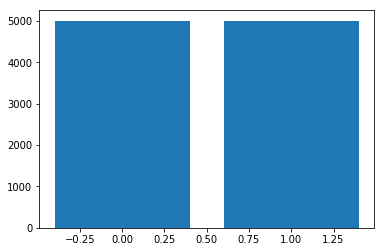

In [12]:
plt.bar([0,1], [counter[0], counter[1]])
plt.show()

In [13]:
import tensorflow as tf

In [14]:
batch_samples = tf.placeholder(shape=[None,None,1], dtype=tf.float32)
batch_labels = tf.placeholder(shape=[None], dtype=tf.uint8)
batch_size = tf.placeholder(shape=(), dtype=tf.int32)

In [15]:
def RNN(input_data, num_layers=3):
#     # create a BasicRNNCell
#     rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=256)

#     # defining initial state
#     initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
    
    # create 2 LSTMCells
    rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [128, 256]]

    # create a RNN cell composed sequentially of a number of RNNCells
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
    
    # 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]
    # 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(multi_rnn_cell, input_data,
                                       # initial_state=initial_state,
                                       dtype=tf.float32)
    
    print(outputs)
    out = tf.layers.flatten(state[-1][-1])
    logits = tf.layers.dense(out, 2, activation=None)
    
    return logits

In [16]:
logits = RNN(batch_samples)
#logits = DNN(batch_samples)
    
predictions = tf.argmax(logits, axis=1)

# accuracy
correct_predictions = tf.equal(predictions, tf.cast(batch_labels, tf.int64))
accuracy_op = tf.reduce_mean(tf.to_float(correct_predictions))

log_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(batch_labels, 2), logits=logits)
cost = tf.reduce_mean(log_loss)

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0006)

model_vars = tf.trainable_variables()
gradients = tf.gradients(cost, model_vars)
#gradients, _ = tf.clip_by_global_norm(gradients, 5.) # gradient clipping

minimize = optimizer.apply_gradients(zip(gradients, model_vars))

In [ ]:
training_loss = []
training_acc = []

train_batch_size = 32
test_batch_size = 1

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    counter = 0
    for i in range(1000):
        counter += 1

        for X_batch, y_batch in next_batch(bucketing_dataset, bucketing_labels, 
                                           batch_size=train_batch_size, 
                                           max_seq_len=max_sequence_length):

            _, train_acc, train_loss = sess.run([minimize, accuracy_op, cost], 
                                                feed_dict={batch_samples: X_batch,
                                                           batch_labels: y_batch,
                                                           batch_size: len(X_batch)})
            training_loss.append(train_loss)
            training_acc.append(train_acc)

    validation_acc = []
    validation_loss = []

    for X_batch, y_batch in zip(testing_data, testing_labels):
        X_batch = np.reshape(X_batch, (1,len(X_batch),1))
        y_batch = np.array([y_batch])

        val_acc, val_cost = sess.run([accuracy_op, cost], feed_dict={batch_samples: X_batch,
                                                                     batch_labels: y_batch,
                                                                     batch_size: len(X_batch)})
        validation_loss.append(val_cost)
        validation_acc.append(val_acc)

In [ ]:
plt.plot(training_loss)
#plt.plot(validation_loss)

In [ ]:
print("Train Mean acc:", np.mean(training_acc))
print("Test Mean acc:", np.mean(validation_acc))

plt.plot(training_acc)
plt.show()

In [ ]:
plt.plot(validation_acc)
plt.show()